Initializing

In [5]:
#imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#retrieving data
path_data = '/Users/alvarochapela/Documents/DATOS_ZRIVE/Module2Data'

orders = pd.read_parquet(f"{path_data}/orders.parquet")
users = pd.read_parquet(f"{path_data}/users.parquet")
regulars = pd.read_parquet(f"{path_data}/regulars.parquet")
inventory = pd.read_parquet(f"{path_data}/inventory.parquet")
abandoned_carts = pd.read_parquet(f"{path_data}/abandoned_carts.parquet")


Starting the analysis

In [2]:
n_regulars = regulars.groupby('user_id')['variant_id'].nunique().reset_index().rename(columns={'variant_id':'n_regulars'})
users = users.merge(n_regulars, on='user_id', how = 'left').fillna({'n_regulars':0})
# Veo los users y quito nulls
users.dropna().head()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets,n_regulars
23,09d70e0b0778117aec5550c08032d56f8e06f992741680...,Proposition,UKI,2021-06-28 12:07:04,2021-06-01 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0
27,4f5ff38ce5ed48096ba80dff80e167db1ad24b9ebdb00c...,Top Up,UKD,2020-06-12 12:07:35,2020-06-01 00:00:00,3.0,2.0,0.0,1.0,0.0,1.0
28,7b2ae50bb11646436fa613394fc3e71e1a0cdc3ba30cdb...,Proposition,UKF,2020-10-03 09:53:57,2020-10-01 00:00:00,2.0,2.0,0.0,0.0,2.0,25.0
35,5e977a4aa2c57f306b8a22f92eaaa177f7dc31a52df82c...,Proposition,UKI,2021-10-14 10:41:13,2021-10-01 00:00:00,2.0,1.0,1.0,0.0,1.0,72.0
66,eafb89ad33eb377adb98a915b6a5a65f1284c2db517d07...,Proposition,UKH,2022-01-20 15:53:09,2022-01-01 00:00:00,2.0,2.0,0.0,0.0,0.0,3.0


Identificar tipos de compradores

In [3]:
user_order_counts = orders.groupby('user_id').size()
frequent_users_ids = user_order_counts[user_order_counts > 1].index
frequent_users_details = users[users['user_id'].isin(frequent_users_ids)]

regular_shoppers = regulars['user_id']
cart_abandoners = abandoned_carts['user_id']
popular_products = orders['id'].explode().value_counts()

loyal_customers = regular_shoppers[regular_shoppers.isin(popular_products.index)]
cart_abandoners_not_regular = cart_abandoners[~cart_abandoners.isin(regular_shoppers)]

In [5]:
frequent_users_details.describe()

,count_people,count_adults,count_children,count_babies,count_pets,n_regulars
count,133.000000,133.000000,133.000000,133.000000,133.000000,1411.000000
mean,2.977444,2.052632,0.834586,0.090226,0.669173,5.343019
std,1.334088,0.907175,0.986119,0.312823,0.974849,11.522472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,0.000000,0.000000,0.000000,1.000000
75%,4.000000,2.000000,2.000000,0.000000,1.000000,5.000000
max,7.000000,7.000000,3.000000,2.000000,6.000000,110.000000


array([[<Axes: title={'center': 'count_people'}>,
        <Axes: title={'center': 'count_adults'}>],
       [<Axes: title={'center': 'count_children'}>,
        <Axes: title={'center': 'count_babies'}>],
       [<Axes: title={'center': 'count_pets'}>,
        <Axes: title={'center': 'n_regulars'}>]], dtype=object)

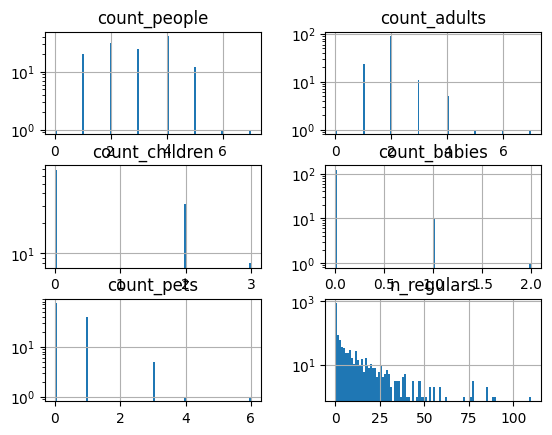

In [7]:
frequent_users_details.hist(bins=100, log=True)

<Axes: >

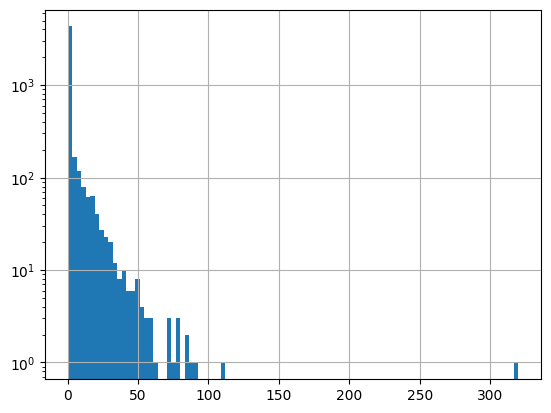

In [8]:
users['n_regulars'].hist(bins=100, log=True)

In [9]:
(users['n_regulars']>7).sum()/len(users)

0.09271523178807947

In [11]:
len(frequent_users_details)/len(users)

0.2831627533614289

In [12]:
family_cols = [col for col in users.columns if col.startswith('count_')]
family_inputs = users.count_people.dropna().count()

d = {f"any_{col}": (users[col] > 0).sum()/family_inputs for col in family_cols}
d

{'any_count_people': 0.9938461538461538,
 'any_count_adults': 0.9907692307692307,
 'any_count_children': 0.4,
 'any_count_babies': 0.07076923076923076,
 'any_count_pets': 0.40615384615384614}

In [13]:
#Casas con niños
(users[['count_children', 'count_babies']].sum(axis=1) > 0).sum() / family_inputs

0.4430769230769231

2. REGULAR PRODUCTS


In [14]:
regulars_df = regulars.merge(inventory, on='variant_id', how='left')
regulars_df.head()



,user_id,variant_id,created_at,price,compare_at_price,vendor,product_type,tags
0,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
1,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
2,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
3,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
4,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11,3.49,3.5,method,cleaning-products,"[cruelty-free, eco, vegan, window-glass-cleaner]"


In [15]:
clean_regular = regulars_df.dropna()
clean_regular.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15034 entries, 4 to 18104
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           15034 non-null  object        
 1   variant_id        15034 non-null  int64         
 2   created_at        15034 non-null  datetime64[us]
 3   price             15034 non-null  float64       
 4   compare_at_price  15034 non-null  float64       
 5   vendor            15034 non-null  object        
 6   product_type      15034 non-null  object        
 7   tags              15034 non-null  object        
dtypes: datetime64[us](1), float64(2), int64(1), object(4)
memory usage: 1.0+ MB


<Axes: xlabel='product_type'>

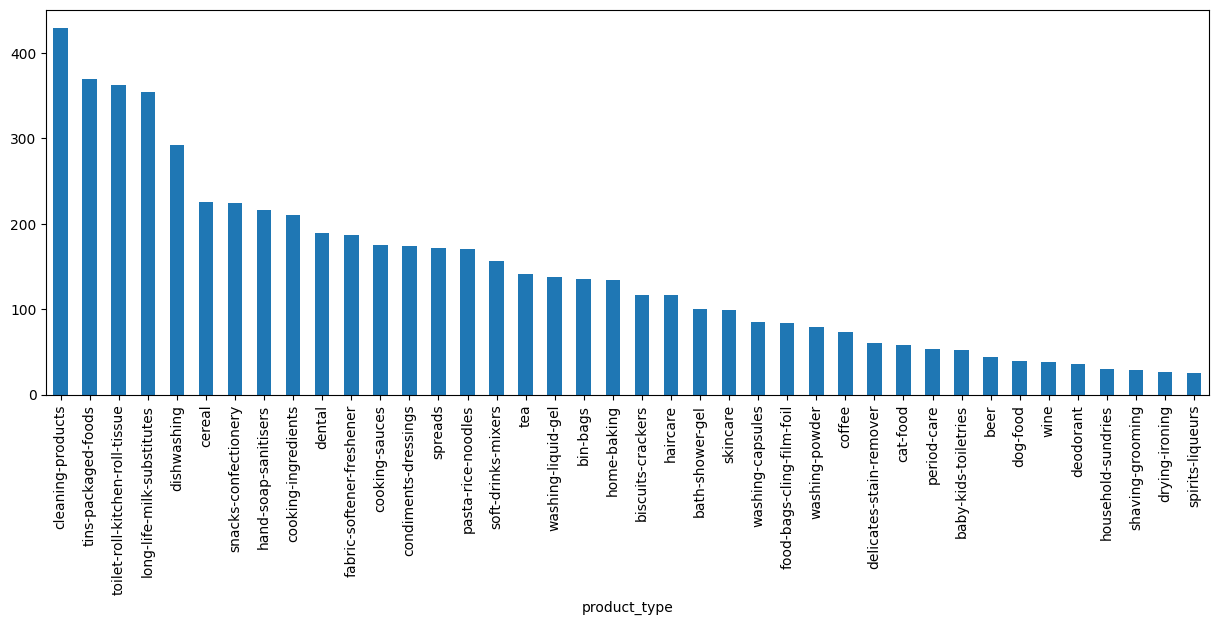

In [17]:
clean_regular.groupby(['product_type'])['user_id'].nunique().sort_values(ascending=False).head(40).plot(kind='bar', figsize=(15,5))

Aquí tenemos las categorías de productos más guardadas en regulars

Ahora vamos a ver la distribución de precios de productos guardados regularmente

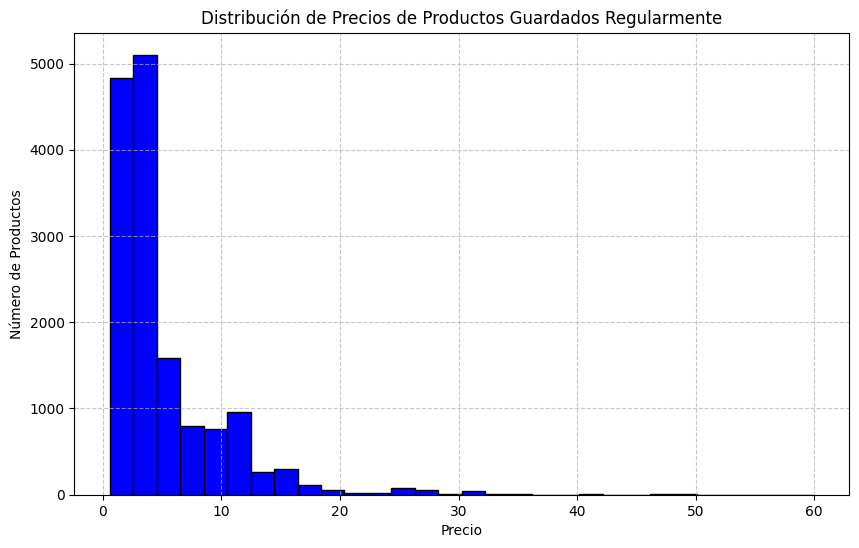

In [21]:
# Histograma para observar cómo se distribuyen los precios de los productos guardados regularmente.
plt.figure(figsize=(10, 6))
plt.hist(clean_regular['price'], bins=30, color='blue', edgecolor='black')
plt.title('Distribución de Precios de Productos Guardados Regularmente')
plt.xlabel('Precio')
plt.ylabel('Número de Productos')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Vamos a comparar los precios para ver si los usuarios tienden a guardar productos en oferta

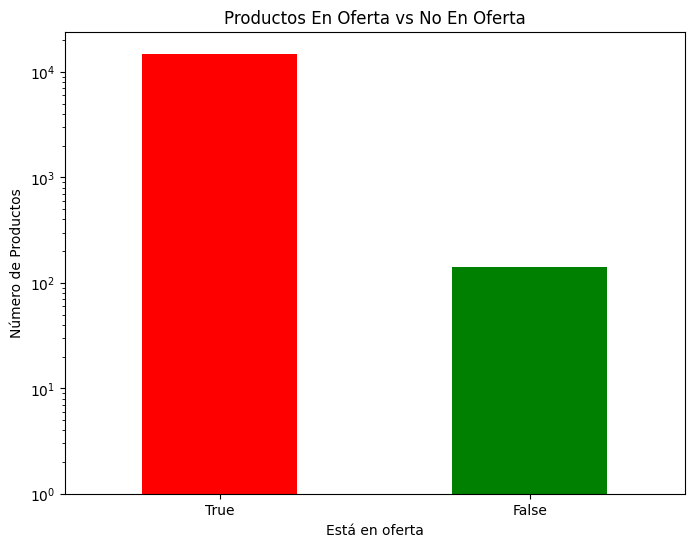

In [24]:
clean_regular.loc[:, 'is_on_offer'] = clean_regular['price'] < clean_regular['compare_at_price']

# Visualización de cuántos productos están en oferta vs. cuántos no lo están
on_offer_counts = clean_regular['is_on_offer'].value_counts()
plt.figure(figsize=(8, 6))
on_offer_counts.plot(kind='bar', color=['red', 'green'], log=True)
plt.title('Productos En Oferta vs No En Oferta')
plt.xlabel('Está en oferta')
plt.ylabel('Número de Productos')
plt.xticks(rotation=0)
plt.show()

Los usuarios guardan muchos más productos en oferta

Vamos a ver las tendencias a lo largo del tiempo


In [30]:
monthly_counts = clean_regular.resample('M', on='created_at').size()


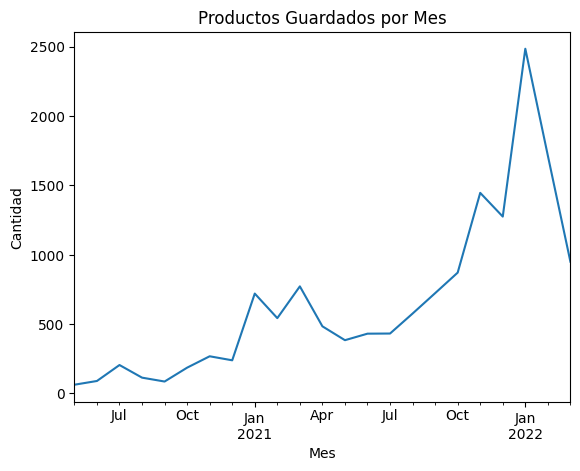

In [31]:
# Visualizar
monthly_counts.plot()
plt.title("Productos Guardados por Mes")
plt.ylabel("Cantidad")
plt.xlabel("Mes")
plt.show()

Vamos a ver los días mas populares

In [34]:
clean_regular['weekday'] = clean_regular['created_at'].dt.day_name()
weekday_counts = clean_regular['weekday'].value_counts()

/var/folders/pw/b4ryzt9s5c5g1n_snb_j6yxw0000gn/T/ipykernel_93091/3488275417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_regular['weekday'] = clean_regular['created_at'].dt.day_name()


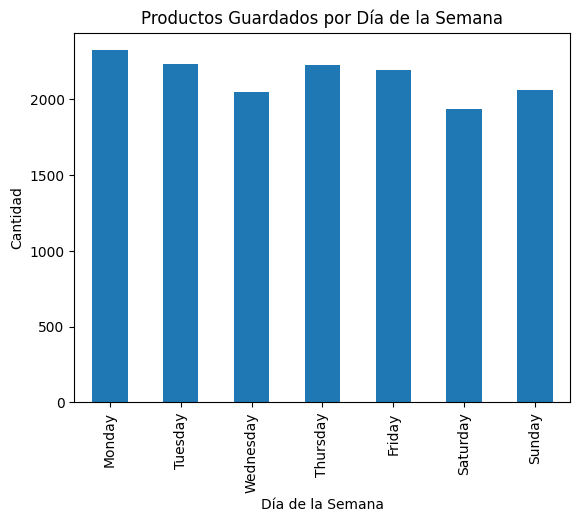

In [35]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(order)

# Visualizar
weekday_counts.plot(kind='bar')
plt.title("Productos Guardados por Día de la Semana")
plt.ylabel("Cantidad")
plt.xlabel("Día de la Semana")
plt.show()

Muy consistente a lo largo de la semana, no hay un día claramente preferido

Vamos a ver los proveedores más populares

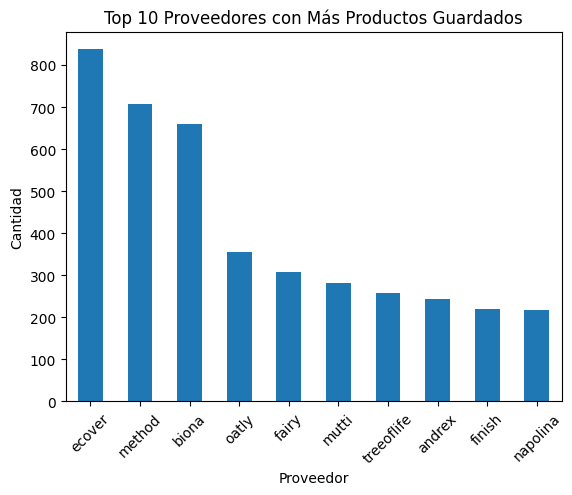

In [37]:
vendor_counts = clean_regular['vendor'].value_counts().head(10) 
# Visualizar
vendor_counts.plot(kind='bar')
plt.title("Top 10 Proveedores con Más Productos Guardados")
plt.ylabel("Cantidad")
plt.xlabel("Proveedor")
plt.xticks(rotation=45)
plt.show()

In [38]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8773 non-null   int64         
 1   user_id         8773 non-null   object        
 2   created_at      8773 non-null   datetime64[us]
 3   order_date      8773 non-null   datetime64[us]
 4   user_order_seq  8773 non-null   int64         
 5   ordered_items   8773 non-null   object        
dtypes: datetime64[us](2), int64(2), object(2)
memory usage: 479.8+ KB


Analisis temporal de orders

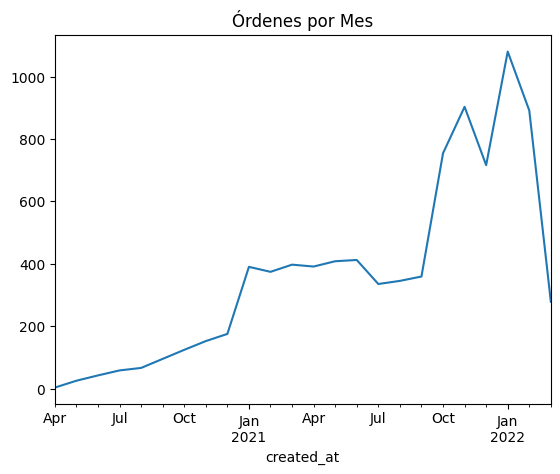

In [39]:
#Como se distribuyen las orders por mes
orders.set_index('created_at').resample('M').size().plot(title='Órdenes por Mes')
plt.show()

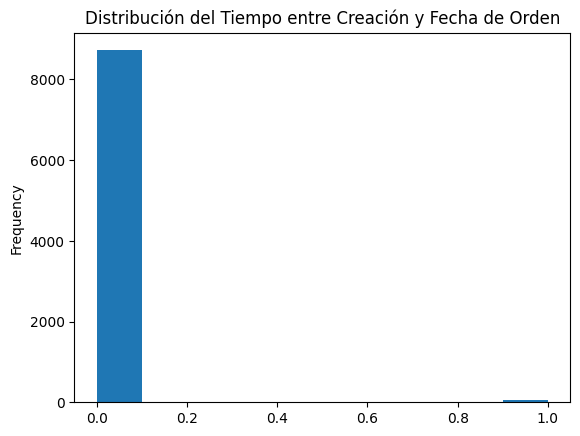

In [41]:
#Tiempo desde que se crea una orden hasta que se hace
orders['time_difference'] = (orders['created_at'] - orders['order_date']).dt.days
orders['time_difference'].plot.hist(title='Distribución del Tiempo entre Creación y Fecha de Orden')
plt.show()

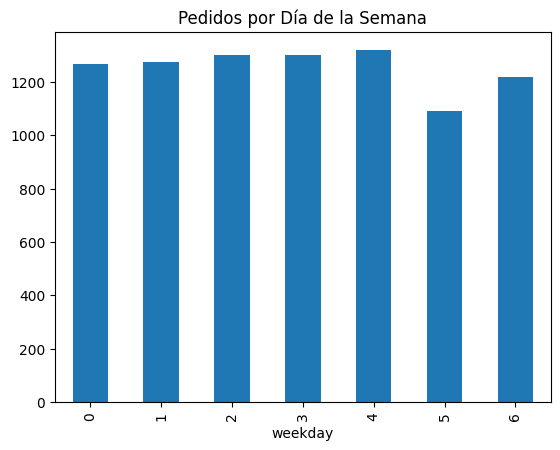

In [6]:
#Dias de la semana mas populares
orders['weekday'] = orders['created_at'].dt.dayofweek
orders.groupby('weekday').size().plot(kind='bar', title='Pedidos por Día de la Semana')
plt.show()


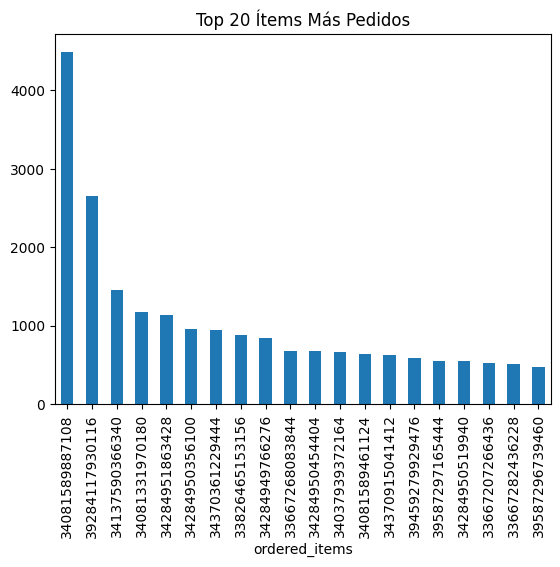

In [7]:
#Productos mas pedidos por los usuarios
orders.explode('ordered_items').groupby('ordered_items').size().sort_values(ascending=False).head(20).plot(kind='bar', title='Top 20 Ítems Más Pedidos')
plt.show()


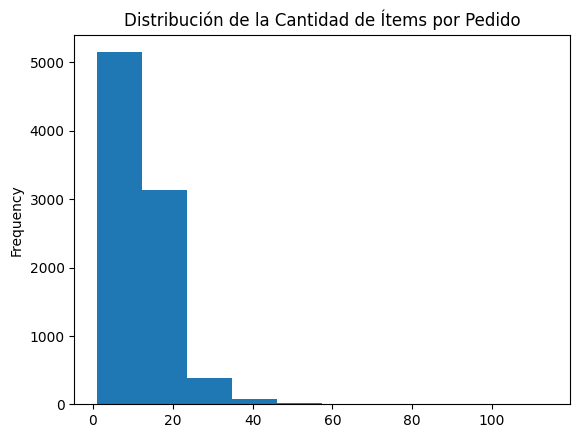

In [8]:
#Cantidad de items que suelen tener los pedidos
orders['num_items'] = orders['ordered_items'].apply(len)
orders['num_items'].plot.hist(title='Distribución de la Cantidad de Ítems por Pedido')
plt.show()
